# Orientation mapping for Molecular Glasses

This notebook looks into doing orientation mapping for polymers using hyperspy and pyxem.  This is a similar work flow for producing figures similar to those in the paper:
```
Using 4D STEM to Probe Mesoscale Order in Molecular Glass Films Prepared by Physical Vapor Deposition
Debaditya Chatterjee, Shuoyuan Huang, Kaichen Gu, Jianzhu Ju, Junguang Yu, Harald Bock, Lian Yu, M. D. Ediger, and Paul M. Voyles
Nano Letters 2023 23 (5), 2009-2015
DOI: 10.1021/acs.nanolett.3c00197
```

In this paper disk like structures in the glass are oriented in domains in the molecular glass.  These domains result from Pi-Pi like stacking and the orientation of the structure can be measured by 4-D STEM. 

Here we will go through the processing in pyxem/ hyperspy to create a figure similar to the image below which comes from the above paper.

<center><img src="data/12/ExampleImage.jpeg" style="height:400px"></center>

This is also a good example of how to develop custom workflows in pyxem.  This might eventaully be added as a supported feature to pyxem/hyperspy using the `Model` class upstream in hyperspy but this requires that parallel processing in `hyperspy` when fitting signals is improved.  

There are a couple of really cool things to focus on. Specifically this make heavy use of the `map` function in order to make these workflows both parallel and operate out of memory. This notebook is also designed to be easy to modify in the case that you have a different function that you want to fit!

The raw data used in section1 can be found at the link below:

https://app.globus.org/file-manager?origin_id=82f1b5c6-6e9b-11e5-ba47-22000b92c6ec&origin_path=%2Fmdf_open%2Fchatterjee_phenester_orientation_v1.3%2FFig2%2Fhttps://app.globus.org/file-manager?origin_id=82f1b5c6-6e9b-11e5-ba47-22000b92c6ec&origin_path=%2Fmdf_open%2Fchatterjee_phenester_orientation_v1.3%2FFig2%2F

# Contents

0. [Loading the Data/Setup](#Section0)
1. [Removing Ellipticity and Polar Unwrapping](#Section1)
2. [Processing the Polar Spectrum](#Section2)
    1. [Smoothing Functions](#Section2a)
3. [Fitting The Polar Spectrum](#Section3)
    1. [Fitting Functions](#Section3a)
    2. [Testing Initial Parameters](#Section3b)
    3. [Visualizing the Results and Checking](#Section3c)
4. [Making a Figure with Flow Lines](#Section4)

<a id='Section0'></a>
# 0. Loading the Data/ Setup

In [1]:
import hyperspy.api as hs # importing hyperspy 

In [2]:
import zarr

In [3]:
store2 = zarr.ZipStore(path="data/12/data_processed.zspy")
s = hs.load(store2, lazy=True)

In [4]:
mean_dp = s.mean()

In [5]:
mean_dp.compute()# Compute the mean Diffraciton pattern

[########################################] | 100% Completed | 203.08 ms


<a id='Section1'></a>
# 1.0 Removing Ellipticity and Polar Unwrapping

Often times you will have some ellipticity in a diffraction pattern or you might not know the exact center. 

In pyxem we have a method `determine_ellipse` which can be used to find some ellipse.  This is useful for patterns where you don't have a zero beam to find the beam shift.  It is a pretty simple function, it just finds the max points in the diffraction pattern and uses those to define an ellipse. 

In [6]:
from pyxem.utils.ransac_ellipse_tools import determine_ellipse, _get_max_positions

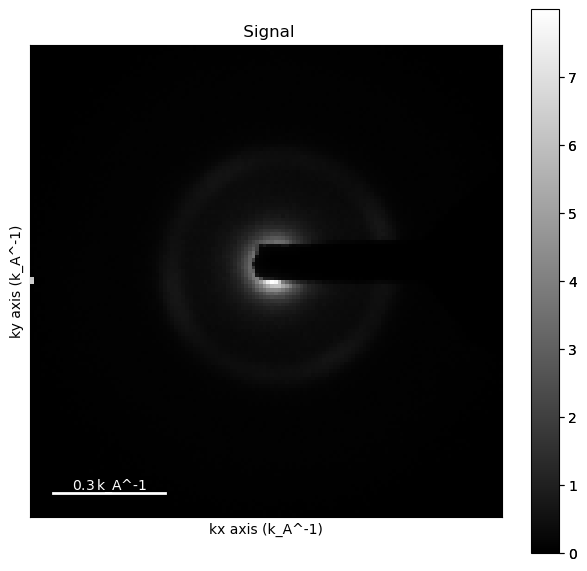

In [7]:
%matplotlib inline
mean_dp.plot()

In [8]:
import numpy as np
from skimage.morphology import disk, dilation
mask  = np.logical_not((mean_dp>.001) * (mean_dp<.8))
mask.data = dilation(mask.data, disk(14))

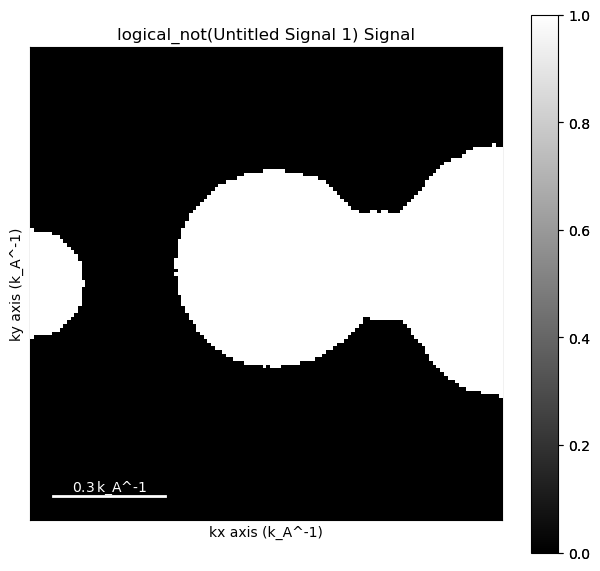

In [9]:
mask.plot()

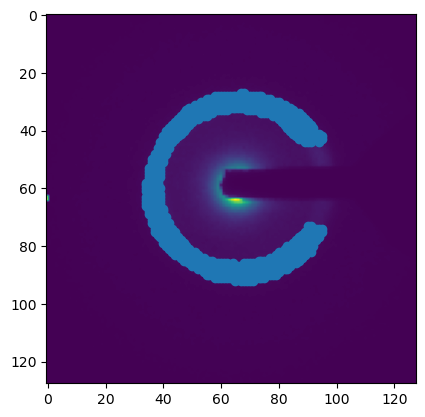

In [10]:
import matplotlib.pyplot as plt
pos = _get_max_positions(mean_dp, mask=mask.data, num_points=900)
plt.figure()
plt.imshow(mean_dp.data)
plt.scatter(pos[:, 1], pos[:,0])

In [11]:
center, affine = determine_ellipse(mean_dp, mask=mask.data, num_points=1000)

In [12]:
affine

array([[0.99722978, 0.00123876, 0.        ],
       [0.00123876, 0.99944606, 0.        ],
       [0.        , 0.        , 1.        ]])

In [13]:
#Polar conversion on mean DP using pyXem
mean_dp.set_signal_type('electron_diffraction') # 
mean_dp.unit = "k_A^-1" # setting unit
mean_dp.beam_energy = 200 # seting beam energy 
mean_dp.camera_length = 1700
mean_dp.set_ai(center=center)

[                                        ] | 0% Completed | 8.44 ms

[########################################] | 100% Completed | 110.68 ms


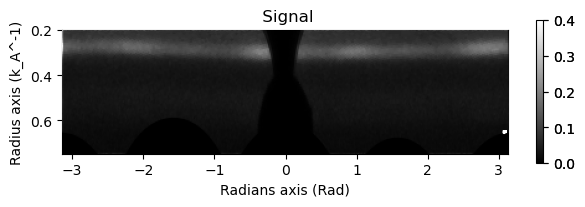

In [14]:
mean_dp.get_azimuthal_integral2d(npt=100,radial_range=(0.2,0.75), sum=True).plot(vmax=.4) 

Now we can use the same parameters on the entire dataset.

In [15]:
#Polar conversion on mean DP using pyXem
s.set_signal_type('electron_diffraction') # 
s.unit = "k_A^-1" # setting unit
s.beam_energy = 200 # seting beam energy 
s.camera_length = 1700
s.set_ai(center=center)

In [16]:
ps = s.get_azimuthal_integral2d(npt=100,radial_range=(0.2,0.75), sum=True) # Use sum=True to conserve counts
pss = ps.isig[:,0.25:0.35].sum(axis=-1) #Radial k-summed azimuthal intensity profiles
pss.compute()

[########################################] | 100% Completed | 8.04 ss


In [17]:
pss.save("data/PolarSum.zspy", overwrite=False) # Saving the data for use later (we are going to use some precomputed stuff which is a little larger)

<a id='Section2'></a>
# 2. Processing the Polar Spectrum


The radial spectra have a fair bit of noise so we should think about filtering the data.  In this case we can smooth the data before fitting the two arcs.  Using a larger sigma smooths the data more at the cost of losing small features in the dataset.

In [18]:
import hyperspy.api as hs

In [19]:
from scipy.ndimage import gaussian_filter1d

In [20]:
pss = hs.load("data/12/PolarSum.zspy", lazy=True)
pss.rechunk((4,4))

In [21]:
pss

<LazySignal1D, title: , dimensions: (127, 127|360)>

[########################################] | 100% Completed | 622.33 ms


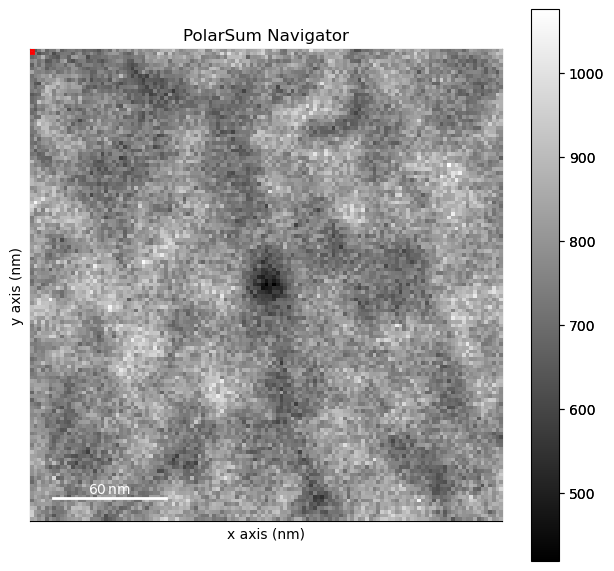

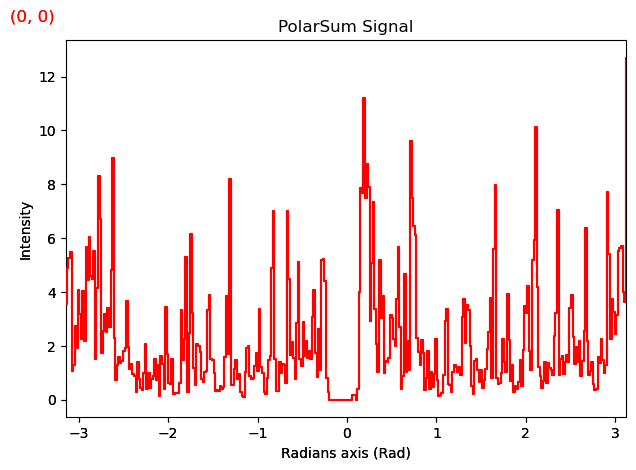

In [22]:
pss.plot()

<a id='Section2a'></a>
## 2a. Smoothing Functions

These are just some custom functions for filtering when there is a zero beam.  It just ignores the zero beam when guassian filtering so that 
intensity doesn't bleed into the masked region

In [23]:
#Helper Functions (can ignore for the most part)
from scipy.ndimage import gaussian_filter1d
import numpy as np
from pyxem.utils.signal import to_hyperspy_index
    
def mask_gaussian1D(data,
                    sigma,
                    masked_region=None,
                   ):
    """Gaussian smooth the data with a masked region which is ignored.
    
    Parameters
    ----------
    data: array-like
        A 1D array to be filtered
    sigma: float
        The sigma used to filter the data
    masked_region: tuple or None
        The region of the data to be ignored
    """
    if masked_region is not None:
        data_smooth = np.zeros(data.shape)
        data_smooth[0:masked_region[0]] = gaussian_filter1d(data[0:masked_region[0]],sigma)
        data_smooth[masked_region[1]:] = gaussian_filter1d(data[masked_region[1]:],sigma)
    else:
        data_smooth = gaussian_filter1d(data,sig)
    return data_smooth

def smooth_signal(signal, sigma, masked_region=None, **kwargs):
    """
    Helper function to smooth a signal.  The masked_region will use real units if the 
    values are floats and pixel units if an int is passed
    """
    if masked_region is not None:
        masked_region =[to_hyperspy_index(m, signal.axes_manager.signal_axes[0]) for m in masked_region]
    return signal.map(mask_gaussian1D, sigma=sigma, masked_region=masked_region, **kwargs)

In [24]:
smoothed = smooth_signal(pss,
                         sigma=5,
                         masked_region=(-0.2, 0.1),
                         inplace=False)

[########################################] | 100% Completed | 3.13 sms


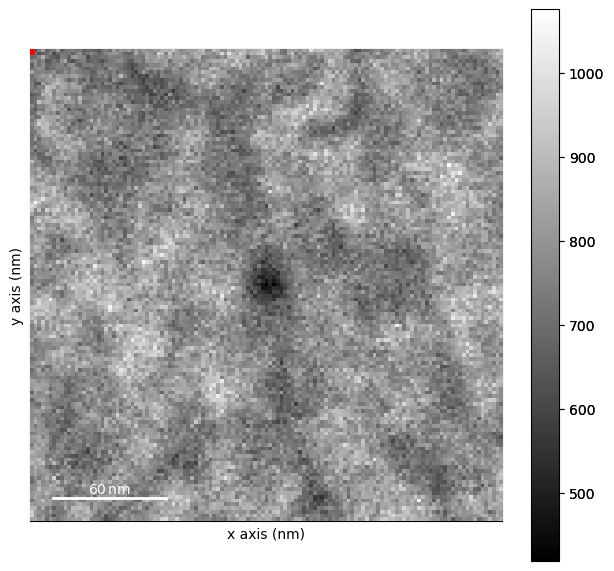

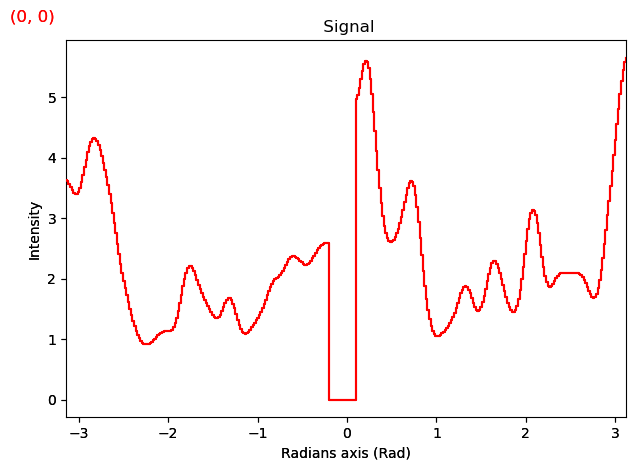

In [25]:
smoothed.plot()

<a id='Section3'></a>
# 3. Fitting The Polar Spectrum

Now that we have a polar spectrum defined we can start to fit the peaks

<a id='Section3a'></a>
## 3.a Fitting Functions

These functions below help to initalize the fit and then to fit the data using the `map` function.  We could equivilently use the hyperspy.model and `multifit` function but the `multifit` function is a little too slow for the amount of data that we want to process.  We also have a very good idea of the location of the peaks in the data from the "guess" and we can use that to our advantage to help speed up the operation.

The model is still a good place to play around with parameters and see if things work for the first position.

In [26]:
# Additional Helper functions for fitting the signal
from functools import partial
from scipy.optimize import curve_fit
# Take initial guess of peak position
def guess_peak(data,kernel):
    x2 = np.linspace(-np.pi,np.pi,360)
    corr = np.correlate(data,kernel,'same')
    x = x2[np.argmax(corr)]
    # if max peak is second peak then shift 180 degrees
    if x > np.pi:
        x = x-np.pi
    elif x<0:
        x =x+np.pi
    return x 
# Gaussian function
def gaussian(x,a,p,sig):
    """
    Parameters:
    -----------
    x: array-like
        The positions at which to ca
    a:
        Height of the Gaussian
    p:
        The Position of the center of the peak
    sigma:
        The sigma value for the gaussian
    """
    return a*np.exp(-(x-p)**2/(2*sig**2))

# Fitting function (single pair)
def composite(x, # phi
              y_offset,# baseline
              peak1_pos,a_peak1, a_peak2, sig,# peak intensities, position and sigma
              beam_stop_pos): # beamstop
    beamstop = np.ones(len(x))
    beamstop[beam_stop_pos[0]:beam_stop_pos[1]]=0
    return (y_offset + 
            gaussian(x, a_peak1, peak1_pos, sig) +
            gaussian(x, a_peak2, peak1_pos-np.pi, sig)+ 
            gaussian(x, a_peak1, peak1_pos+np.pi, sig))*beamstop

# Fit peak parameters
def peak_fit(data,
             composite, 
             fixed_parameters,
             bounds,
             fitting_kwds = ["y_offset", "peak1_pos", "a_peak1", "a_peak2", "sig"],
             method='chi2',
             **kwargs):
    """
    A general function to fit the composite function defined above.
    
    This function can be generalized to any composite function by creating a new function.
    
    The fixed parameters are fixed during the fitting while other kwargs passed only represent the initial parameters for fitting
    and are iteratively changed to minimize the cost function.
    
    Parameters
    ----------
    data: np.array
        The data to be fit. A 1-D array
    composite: func
        The funtion to be fit
    fixed_parameters: dict
        A dictionary mapping between the fixed parameters for the function that is being optimized. 
    bounds: 
        The bounds for the parameters which are being fit in a dictionary
        i.e.: bounds = {"y_offset":(low_y, hi_y), "peak1_pos":(low_pos, hi_pos),}
    fitting_kwds: list
        The list of keywords that are passed to the function to be fit.
    method:
        The statistical analysis of the fit to return
    kwargs:
        The inital values for the composite function as well as any keyword arguments for `scipy.optimize.curve_fit`
    """
    data = data+0.00000000001 # handle zeros
    
    comp = partial(composite, **fixed_parameters) # set fixed values
    x2 = np.linspace(-np.pi,np.pi,360)
    initial_guess = [kwargs.pop(k, 1) for k in fitting_kwds]
    unpacked_bounds = (tuple([bounds.get(k, (-np.inf, np.inf))[0] for k in fitting_kwds]),
                       tuple([bounds.get(k, (-np.inf, np.inf))[1] for k in fitting_kwds]))
    try:
        popt,pcov = curve_fit(comp,
                              x2,
                              data,
                              p0=initial_guess,
                              bounds=unpacked_bounds,
                              sigma=1/np.power(data,1/4),
                              method='trf',
                              **kwargs)
    except:
        return [1,0,0,0,0,0]

    if method == 'std':
        gof = np.sum(np.sqrt(np.diag(pcov)))
    if method == 'chi2':
        gof = np.nansum(((comp(x2, *popt)-data)**2/data)[data>0])/(360-len(unpacked_bounds[0]))
    if method == 'r2':
        ss_tot = np.sum((data-np.mean(data))**2)
        ss_res = np.sum((data-comp(x2, *popt))**2)
        gof = 1-ss_res/ss_tot
    return np.array([gof,*popt])

In [27]:
x2 = np.linspace(-np.pi,np.pi,360)
kernel = gaussian(x2,35,0,0.36)+8
orientation_guess = smoothed.map(guess_peak,
                         kernel=kernel,
                         inplace=False)

In [28]:
orientation_guess

<LazySignal, title: , dimensions: (127, 127|)>

In [29]:
orientation_guess.compute()

[########################################] | 100% Completed | 5.26 sms


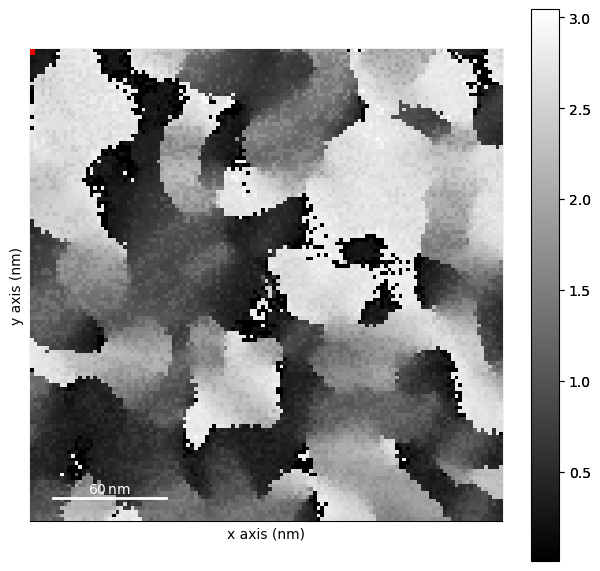

In [30]:
orientation_guess.plot()

In [31]:
# Inital Parameters for fitting
bounds = {"y_offset": (0,2),
          "peak1_pos": (0, np.pi),
          "a_peak1":(2, 15),
          "a_peak2":(2,15),
          "sig": (0.1, 0.3)
         }

inital_pos = {"y_offset": 1,
              "a_peak1":4,
              "a_peak2":4,
              "sig":.2,}
beam_stop_pos = [to_hyperspy_index(edge, smoothed.axes_manager.signal_axes[0]) for edge in (-0.2, 0.1)]

fixed_parameters = {"beam_stop_pos":beam_stop_pos}

<a id='Section3b'></a>

## 3.b Testing Inital Parameters:

Let's look at one position in the dataset and see if our inital parameters and bounds are reasonable. You have to adjust these values a little bit 
to make things a little easier to fit.

In [32]:
data = smoothed.inav[4,4].data.compute()
orientation = orientation_guess.inav[4,4].data[0]

In [33]:
peaks = smoothed.map(peak_fit,
                     composite=composite,
                     fixed_parameters=fixed_parameters,
                     bounds=bounds,
                     peak1_pos=orientation_guess,
                     inplace=False,
                     **inital_pos,
                    )

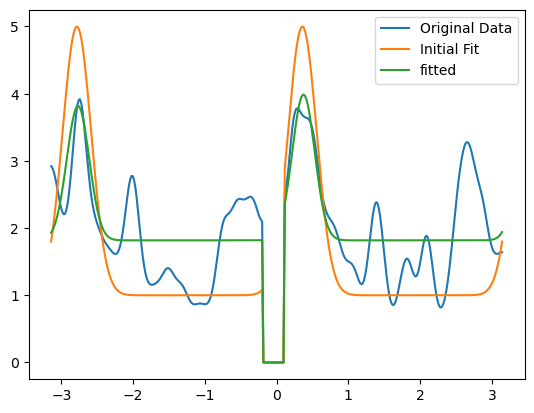

In [34]:
import matplotlib.pyplot as plt
plt.figure()
x = np.linspace(-np.pi,np.pi,360)
plt.plot(x, data, label="Original Data")

initial_fit = composite(x,
                        beam_stop_pos=beam_stop_pos,
                        peak1_pos=orientation,
                        **inital_pos,
                       )
plt.plot(x,
         initial_fit,
         label="Initial Fit")

fitted = peak_fit(data,
                  composite=composite,
                  fixed_parameters=fixed_parameters,
                  bounds=bounds,
                  peak1_pos=orientation,
                  **inital_pos,)
plt.plot(x,composite(x,
                     *fitted[1:],
                     beam_stop_pos=beam_stop_pos,
                    ),
         label="fitted")
plt.legend()
plt.show()

In [35]:

beam_stop_pos = [to_hyperspy_index(edge, smoothed.axes_manager.signal_axes[0]) for edge in (-0.2, 0.1)]
peaks = smoothed.map(peak_fit,
                     composite=composite,
                     fixed_parameters=fixed_parameters,
                     bounds=bounds,
                     peak1_pos=orientation_guess,
                     inplace=False,
                     **inital_pos,
                    )

In [36]:
peaks.data[3,4].compute()

array([0.2432117 , 1.42473297, 0.27754391, 3.27041607, 2.03215613,
       0.26445866])

In [ ]:
# Run fitting in parallel (Should take a minute or two)
peaks.compute()

[##                                      ] | 6% Completed | 11.92 sms

In [ ]:
import matplotlib.pyplot as plt
hs.plot.plot_images(peaks.T,
                    label=["Chi^2","Backgrond", "Orientation", "Peak1 Amplitude", "Peak2 Amplitude", "Sigma"],
                per_row=3, tight_layout=True, scalebar="all", axes_decor="off",scalebar_color="white", cmap="hot")
plt.show()

<a id='Section3c'></a>
## 3.c Visualizing the Results and Checking for Accuracy

We can always see how well our fit performed but plotting both signals on top of each other. 

In [ ]:
# creating a cyclical mcap from 0-> pi
from matplotlib.colors import LinearSegmentedColormap
cdata = np.loadtxt('data/12/colorwheel.txt')
cmap= LinearSegmentedColormap.from_list('my_colormap', cdata)

In [ ]:
def apply_composite(data):
    x = np.linspace(-np.pi,np.pi,360)
    return composite(x,*data[1:], beam_stop_pos=beam_stop_pos,)

In [ ]:
ans = peaks.map(apply_composite, inplace=False)

In [ ]:
# Just add in the answer as a complex signal.
both = smoothed+ans.data*1j
both.metadata.General.title= "Fit+Smoothed Data"

In [ ]:
%matplotlib inline
both.navigator = peaks.isig[2]
both.axes_manager.navigation_axes[0].index=12
both.axes_manager.navigation_axes[1].index=15
both.plot(navigator_kwds={"cmap":cmap,
                          "interpolation":'none'})

<a id='Section4'></a>
# 4.0 Making a Nice Figure with Flow Lines

Now we can make a nice figure with some Flow/ Orientataion arrows.  

In [ ]:
peaks.axes_manager.navigation_shape

In [ ]:
fig, axs = plt.subplots(1)

im = axs.imshow(peaks.isig[2].data,
           cmap=cmap, interpolation='none', 
           extent=peaks.axes_manager.navigation_extent)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=24, weight="bold")

scalebar = AnchoredSizeBar(axs.transData,
                           80, '80 nm', 'lower left', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=7,
                           fontproperties=fontprops)

axs.add_artist(scalebar)
axs.set_xticks([])
axs.set_yticks([])
cbar = fig.colorbar(im, ax=axs)
cbar.set_ticks([0, np.pi/2, np.pi])
cbar.set_ticklabels(["0", "$\pi/2$", "$\pi$"])
cbar.set_label("Orientation")
vx = np.cos(peaks.isig[2].data)
vy = np.sin(peaks.isig[2].data)

nav_axes = peaks.axes_manager.navigation_axes
sep =7
axs.quiver(nav_axes[1].axis[::sep],nav_axes[0].axis[::sep], vx[::sep,::sep], vy[::sep, ::sep],)